In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
# 열 다 보이게 설정
pd.set_option('display.max_columns', None)
# 행 다 보이게 설정
pd.set_option('display.max_rows', None)

## 데이터 로드

In [4]:
train_path = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/train.csv'
test_path  = '/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [5]:
train.shape, test.shape

((1118822, 52), (9272, 51))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [7]:
train.isnull().sum()

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

# EDA

In [8]:
# 데이터 전처리

# train/test 구분을 위한 칼럼(data)
# train과 test를 하나의 데이터로 만들기

train['data'] = 0
test['data'] = 1
concat = pd.concat([train, test])

print(concat.shape)
print(concat['data'].value_counts())

(1128094, 53)
0    1118822
1       9272
Name: data, dtype: int64


In [9]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [10]:
# 결측치 탐색 및 보간

# 열 전체를 넣고 스캔하기

for col in concat.columns:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    missing_count = concat[col].isnull().sum()
    col_type = concat.dtypes[col]
    print(f"📌 {col:30} | 데이터타입: {col_type} | 고유값: {nunique:6} | 결측개수: {missing_count} | 결측률: {missing_ratio:.2%}")

📌 시군구                            | 데이터타입: object | 고유값:    339 | 결측개수: 0 | 결측률: 0.00%
📌 번지                             | 데이터타입: object | 고유값:   6579 | 결측개수: 227 | 결측률: 0.02%
📌 본번                             | 데이터타입: float64 | 고유값:   1524 | 결측개수: 75 | 결측률: 0.01%
📌 부번                             | 데이터타입: float64 | 고유값:    330 | 결측개수: 75 | 결측률: 0.01%
📌 아파트명                           | 데이터타입: object | 고유값:   6550 | 결측개수: 2136 | 결측률: 0.19%
📌 전용면적                           | 데이터타입: float64 | 고유값:  14670 | 결측개수: 0 | 결측률: 0.00%
📌 계약년월                           | 데이터타입: int64 | 고유값:    201 | 결측개수: 0 | 결측률: 0.00%
📌 계약일                            | 데이터타입: int64 | 고유값:     31 | 결측개수: 0 | 결측률: 0.00%
📌 층                              | 데이터타입: int64 | 고유값:     73 | 결측개수: 0 | 결측률: 0.00%
📌 건축년도                           | 데이터타입: int64 | 고유값:     60 | 결측개수: 0 | 결측률: 0.00%
📌 도로명                            | 데이터타입: object | 고유값:   9245 | 결측개수: 0 | 결측률: 0.00%
📌 해제사유발생일                        | 데이터타입: float6

In [11]:
# 결측치는 아닌데 의미 없는 형식적 값 찾기

def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if concat[col].dtype == 'object':
            val_counts = concat[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()

🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64

🔎 k-시행사 컬럼에서 의미 없는 값 발견:
.    868
-    152
Name: k-시행사, dtype: int64

🔎 k-홈페이지 컬럼에서 의미 없는 값 발견:
없음    3628
.       72
Name: k-홈페이지, dtype: int64



In [12]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)
concat['k-시행사'] = concat['k-시행사'].replace('.', np.nan)
concat['k-시행사'] = concat['k-시행사'].replace('-', np.nan)
concat['k-홈페이지'] = concat['k-홈페이지'].replace('없음', np.nan)
concat['k-홈페이지'] = concat['k-홈페이지'].replace('.', np.nan)

In [13]:
# 열 전체를 넣고 스캔하기

for col in concat.columns:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    missing_count = concat[col].isnull().sum()
    col_type = concat.dtypes[col]
    print(f"📌 {col:30} | 데이터타입: {col_type} | 고유값: {nunique:6} | 결측개수: {missing_count} | 결측률: {missing_ratio:.2%}")

📌 시군구                            | 데이터타입: object | 고유값:    339 | 결측개수: 0 | 결측률: 0.00%
📌 번지                             | 데이터타입: object | 고유값:   6579 | 결측개수: 227 | 결측률: 0.02%
📌 본번                             | 데이터타입: float64 | 고유값:   1524 | 결측개수: 75 | 결측률: 0.01%
📌 부번                             | 데이터타입: float64 | 고유값:    330 | 결측개수: 75 | 결측률: 0.01%
📌 아파트명                           | 데이터타입: object | 고유값:   6550 | 결측개수: 2136 | 결측률: 0.19%
📌 전용면적                           | 데이터타입: float64 | 고유값:  14670 | 결측개수: 0 | 결측률: 0.00%
📌 계약년월                           | 데이터타입: int64 | 고유값:    201 | 결측개수: 0 | 결측률: 0.00%
📌 계약일                            | 데이터타입: int64 | 고유값:     31 | 결측개수: 0 | 결측률: 0.00%
📌 층                              | 데이터타입: int64 | 고유값:     73 | 결측개수: 0 | 결측률: 0.00%
📌 건축년도                           | 데이터타입: int64 | 고유값:     60 | 결측개수: 0 | 결측률: 0.00%
📌 도로명                            | 데이터타입: object | 고유값:   9245 | 결측개수: 1211 | 결측률: 0.11%
📌 해제사유발생일                        | 데이터타입: flo

In [14]:
# print(concat.shape[0] * 0.8) = 902475.2000000001
# Null값이 90만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 90만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 900000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 90만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 900000]))

* 결측치가 90만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'data']
* 결측치가 90만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']


In [15]:
# 결측치 90만개 이상인 값과 이하지만 필요없는 것 제외
# 필요없어 보이는 것 : k-전화번호, k-팩스번호, 사용허가여부, 관리비 업로드, k-수정일자

valid_cols = concat.columns[concat.isnull().sum() <= 900000]
exclude_cols = ['k-전화번호', 'k-팩스번호', '사용허가여부', '관리비 업로드', 'k-수정일자']

select = [col for col in valid_cols if col not in exclude_cols]
concat_select = concat[select]

concat.shape, concat_select.shape

((1128094, 53), (1128094, 39))

In [16]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 39 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1126883 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-세대타입(분양형태)            251969 non-null   object 
 13  k-관리방식                  251969 non-null   object 
 14  k-복도유

In [17]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [18]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
# 숫자형 분리 pd.api.types.is_numeric_dtype
con_columns = []
cat_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        con_columns.append(column)
    else:
        cat_columns.append(column)

print("연속형 변수:", con_columns)
print("범주형 변수:", cat_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일']


In [19]:
def null_summary(df, columns):
    result = pd.DataFrame({
        '결측 개수': df[columns].isnull().sum(),
        '결측 비율(%)': df[columns].isnull().mean() * 100
    })
    return result[result['결측 개수'] > 0].sort_values('결측 비율(%)', ascending=False)

print("📊 연속형 변수 결측치 요약")
display(null_summary(concat_select, con_columns))

print("📊 범주형 변수 결측치 요약")
display(null_summary(concat_select, cat_columns))


📊 연속형 변수 결측치 요약


,결측 개수,결측 비율(%)
k-전체동수,877207,77.760098
건축면적,876279,77.677835
주차대수,876277,77.677658
좌표X,876232,77.673669
좌표Y,876232,77.673669
k-주거전용면적,876170,77.668173
k-전용면적별세대현황(60㎡이하),876170,77.668173
k-전용면적별세대현황(60㎡~85㎡이하),876170,77.668173
k-85㎡~135㎡이하,876170,77.668173
k-전체세대수,876125,77.664184


📊 범주형 변수 결측치 요약


,결측 개수,결측 비율(%)
세대전기계약방법,885389,78.485392
k-시행사,878854,77.906096
청소비관리형태,877751,77.808321
k-건설사(시공사),877637,77.798215
경비비관리형태,877561,77.791478
"k-단지분류(아파트,주상복합등등)",877273,77.765949
단지승인일,876854,77.728806
k-복도유형,876454,77.693348
k-사용검사일-사용승인일,876259,77.676062
단지신청일,876187,77.669680


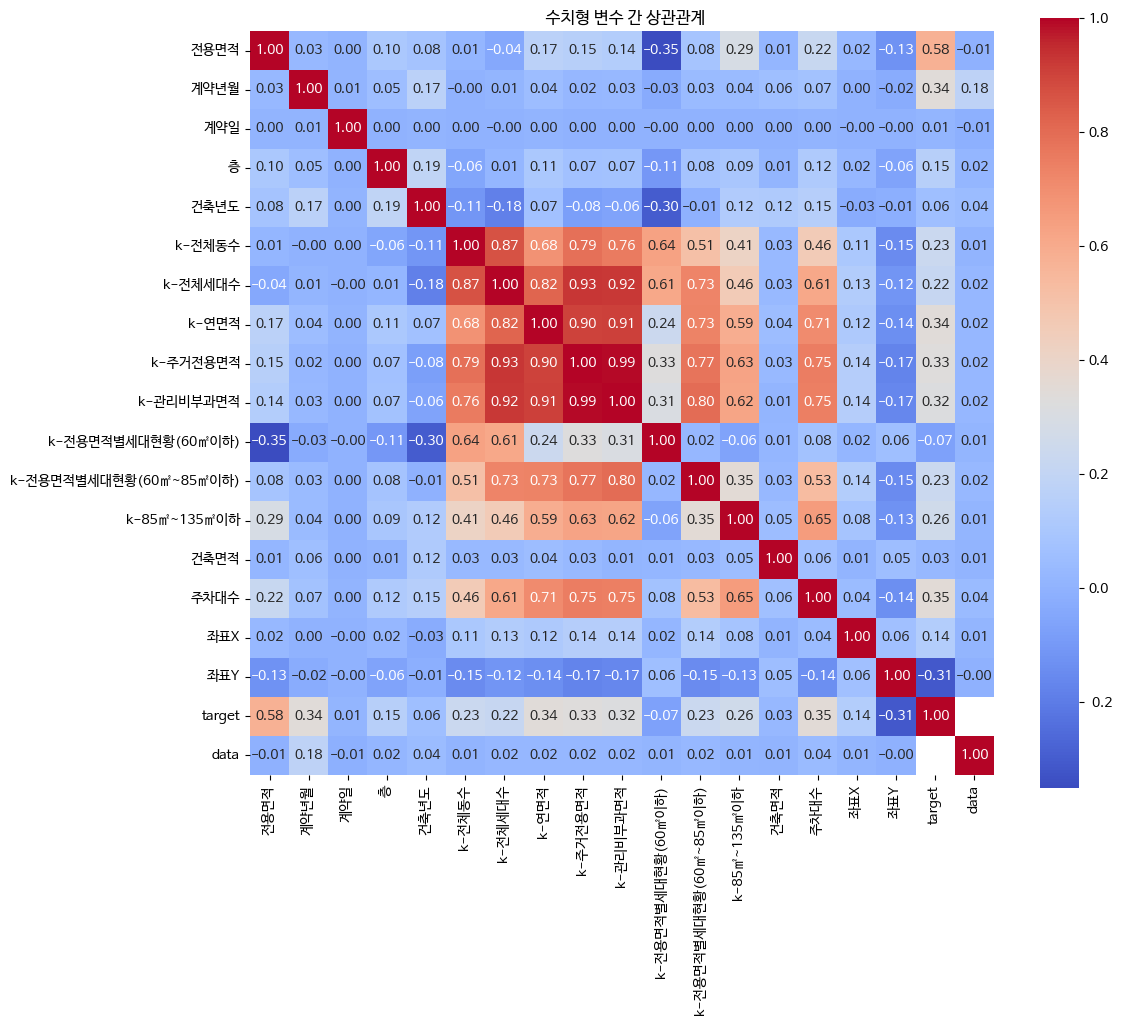

In [20]:
# 결측치 탐지 및 처리 전 연속형 변수 상관관계 보기

# 1. 수치형 변수만 선택
numeric_cols = concat_select.select_dtypes(include=['float64', 'int64']).columns

# 2. 상관관계 계산
corr = concat_select[numeric_cols].corr()

# 3. 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("📊 수치형 변수 간 상관관계")
plt.show()

In [21]:
# 상관관계 기반으로 중복 feature 쌍 탐지 및 삭제 후보 추천

# 연속형 변수만 추출
numeric_cols = con_columns  # ← 너가 나눠둔 연속형 변수 리스트

# 상관관계 행렬 (절댓값 기준)
corr_matrix = concat_select[numeric_cols].corr().abs()

# 상삼각 행렬로 중복 제거
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 상관계수 0.9 초과인 변수쌍 추출
high_corr_pairs = [(col, row, upper.loc[row, col])
                   for col in upper.columns
                   for row in upper.index
                   if pd.notnull(upper.loc[row, col]) and upper.loc[row, col] > 0.7]

# 출력
for col1, col2, score in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"🔁 {col1} ↔ {col2} : 상관계수 = {score:.2f}")


🔁 k-관리비부과면적 ↔ k-주거전용면적 : 상관계수 = 0.99
🔁 k-주거전용면적 ↔ k-전체세대수 : 상관계수 = 0.93
🔁 k-관리비부과면적 ↔ k-전체세대수 : 상관계수 = 0.92
🔁 k-관리비부과면적 ↔ k-연면적 : 상관계수 = 0.91
🔁 k-주거전용면적 ↔ k-연면적 : 상관계수 = 0.90
🔁 k-전체세대수 ↔ k-전체동수 : 상관계수 = 0.87
🔁 k-연면적 ↔ k-전체세대수 : 상관계수 = 0.82
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-관리비부과면적 : 상관계수 = 0.80
🔁 k-주거전용면적 ↔ k-전체동수 : 상관계수 = 0.79
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-주거전용면적 : 상관계수 = 0.77
🔁 k-관리비부과면적 ↔ k-전체동수 : 상관계수 = 0.76
🔁 주차대수 ↔ k-주거전용면적 : 상관계수 = 0.75
🔁 주차대수 ↔ k-관리비부과면적 : 상관계수 = 0.75
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-연면적 : 상관계수 = 0.73
🔁 k-전용면적별세대현황(60㎡~85㎡이하) ↔ k-전체세대수 : 상관계수 = 0.73
🔁 주차대수 ↔ k-연면적 : 상관계수 = 0.71


In [22]:
# 전용면적별세대현황 시리즈끼리 상관관계가 있음 -> 유사하다고 판단
# 전용면적별세대현황 pca 진행

pca_cols = [
    'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)',
    'k-85㎡~135㎡이하'
]
pca_data = concat_select[pca_cols].fillna(0)  # 혹시 모르니 결측 0으로 대체


In [23]:
# pca 진행할 feature 정규화

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_pca_data = scaler.fit_transform(pca_data)


In [24]:
# pca 적용

from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # 2개 성분으로 축소
pca_components = pca.fit_transform(scaled_pca_data)


In [25]:
print(pca.explained_variance_ratio_)  # 예: [0.83, 0.16]


[0.55723546 0.28291263]


In [26]:
# PCA 결과 저장
concat_select["세대면적_PCA1"] = pca_components[:, 0]
concat_select["세대면적_PCA2"] = pca_components[:, 1]

# 원본 feature 제거
concat_select.drop(columns=pca_cols, inplace=True)


In [27]:
# 그다음으로 변수 간 상관관계 있는 feature 제거

drop_cols = ['k-관리비부과면적','k-연면적','k-전체동수']
concat_select.drop(columns=drop_cols, inplace=True)


In [28]:
concat_select.head(1)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,좌표X,좌표Y,단지신청일,target,data,세대면적_PCA1,세대면적_PCA2
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,아파트,분양,자치관리,계단식,개별난방,270.0,우성건설,모름,1987-11-21 00:00:00.0,20204.0,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,-0.030656,-0.171063


In [29]:
concat_select.shape

(1128094, 35)

In [30]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
# 숫자형 분리 pd.api.types.is_numeric_dtype
con_columns2 = []
cat_columns2 = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        con_columns2.append(column)
    else:
        cat_columns2.append(column)

print("연속형 변수:", con_columns2)
print("범주형 변수:", cat_columns2)

def null_summary(df, columns):
    result = pd.DataFrame({
        '결측 개수': df[columns].isnull().sum(),
        '결측 비율(%)': df[columns].isnull().mean() * 100
    })
    return result[result['결측 개수'] > 0].sort_values('결측 비율(%)', ascending=False)

print("📊 연속형 변수 결측치 요약")
display(null_summary(concat_select, con_columns2))

print("📊 범주형 변수 결측치 요약")
display(null_summary(concat_select, cat_columns2))


연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체세대수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data', '세대면적_PCA1', '세대면적_PCA2']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일']
📊 연속형 변수 결측치 요약


,결측 개수,결측 비율(%)
건축면적,876279,77.677835
주차대수,876277,77.677658
좌표X,876232,77.673669
좌표Y,876232,77.673669
k-주거전용면적,876170,77.668173
k-전체세대수,876125,77.664184
target,9272,0.821917


📊 범주형 변수 결측치 요약


,결측 개수,결측 비율(%)
세대전기계약방법,885389,78.485392
k-시행사,878854,77.906096
청소비관리형태,877751,77.808321
k-건설사(시공사),877637,77.798215
경비비관리형태,877561,77.791478
"k-단지분류(아파트,주상복합등등)",877273,77.765949
단지승인일,876854,77.728806
k-복도유형,876454,77.693348
k-사용검사일-사용승인일,876259,77.676062
단지신청일,876187,77.669680


In [31]:
# 연속형 변수 동 단위 평균으로 결측치 채우기
# target은 건들지 말아보자

concat_select['구'] = concat_select['시군구'].str.split().str[1]
concat_select['동'] = concat_select['시군구'].str.split().str[2]

impute_targets = ['건축면적', '주차대수', '좌표X', '좌표Y', 'k-주거전용면적', 'k-전체세대수']

for col in impute_targets:
    # 1차: 동 단위 평균
    concat_select[col] = concat_select.groupby('동')[col].transform(lambda x: x.fillna(x.mean()))
    # 2차: 구 단위 평균 (동 평균이 안 되면 여기서)
    concat_select[col] = concat_select.groupby('구')[col].transform(lambda x: x.fillna(x.mean()))
    # 3차: 전체 평균 (구 평균도 안 되면 여기서)
    concat_select[col].fillna(concat_select[col].mean(), inplace=True)



In [32]:
for col in impute_targets:
    print(f"{col} 결측치 수: {concat_select[col].isnull().sum()}")

건축면적 결측치 수: 0
주차대수 결측치 수: 0
좌표X 결측치 수: 0
좌표Y 결측치 수: 0
k-주거전용면적 결측치 수: 0
k-전체세대수 결측치 수: 0


In [33]:
# 범주형 변수 결측치 채우기

cat_with_na = [
    '세대전기계약방법', 'k-시행사', '청소비관리형태', 'k-건설사(시공사)',
    '경비비관리형태', 'k-단지분류(아파트,주상복합등등)', '단지승인일',
    'k-복도유형', 'k-사용검사일-사용승인일', '단지신청일',
    'k-난방방식', 'k-관리방식', 'k-세대타입(분양형태)',
    '기타/의무/임대/임의=1/2/3/4', '아파트명', '도로명', '번지'
]

for col in cat_with_na:
   
    concat_select[col] = concat_select[col].fillna("Unknown")


In [34]:
concat_select.isnull().sum()

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-주거전용면적                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                      0
기타/의무/임대/임의=1/2/3/4       0
단지승인일                     0
좌표X                       0
좌표Y                       0
단지신청일                     0
target                 9272
data                      0
세대면적_PCA1                 0
세대면적_PCA2                 0
구                   

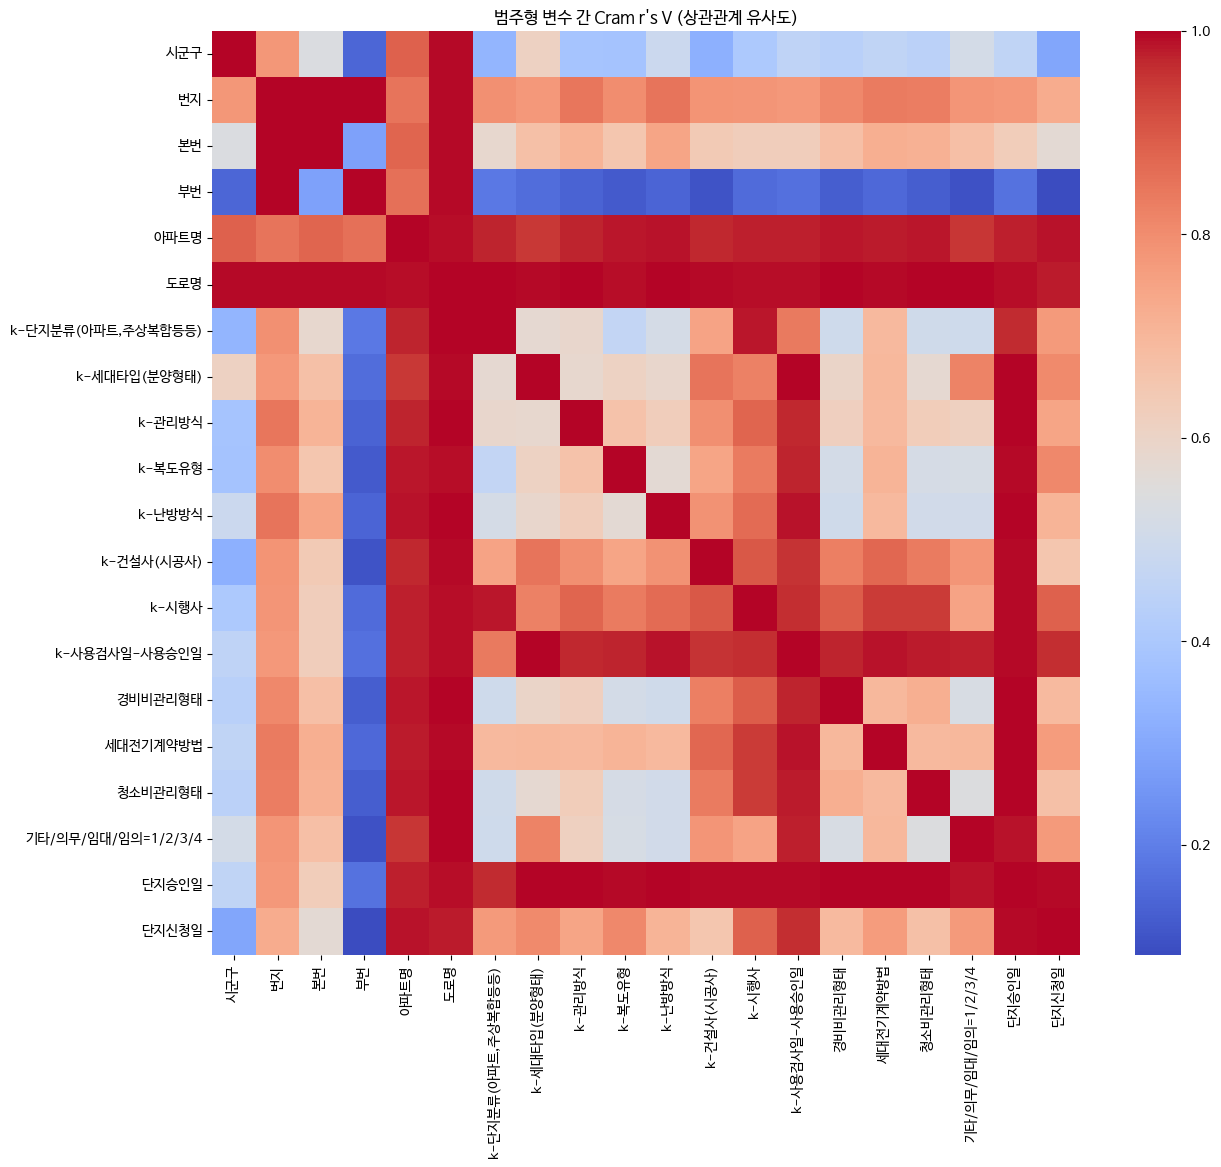

In [35]:
# 범주형 feature들 관계 보기

from scipy.stats import chi2_contingency

# Cramér's V 계산 함수
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# 범주형 변수 리스트
cat_cols = cat_columns2  # 이미 나눈 리스트

# 결과 저장용 매트릭스
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            try:
                cramer_matrix.loc[col1, col2] = cramers_v(concat_select[col1], concat_select[col2])
            except:
                cramer_matrix.loc[col1, col2] = np.nan

plt.figure(figsize=(14, 12))
sns.heatmap(cramer_matrix.astype(float), cmap='coolwarm', annot=False)
plt.title("범주형 변수 간 Cramér's V (상관관계 유사도)")
plt.show()


In [36]:
# 유니크 값이 낮으면 값이 다양하지 않아 유사성이 높을 수 있다고 함
# 변주형 중 unique값이 낮은 것

for col in cat_columns2:
    print(f"{col}: {concat_select[col].nunique()}")


시군구: 339
번지: 6579
본번: 1524
부번: 330
아파트명: 6550
도로명: 9245
k-단지분류(아파트,주상복합등등): 6
k-세대타입(분양형태): 4
k-관리방식: 4
k-복도유형: 6
k-난방방식: 5
k-건설사(시공사): 345
k-시행사: 555
k-사용검사일-사용승인일: 675
경비비관리형태: 5
세대전기계약방법: 3
청소비관리형태: 5
기타/의무/임대/임의=1/2/3/4: 5
단지승인일: 737
단지신청일: 261


In [37]:
# 크래머스 브이 수치로 보기

threshold = 0.8
high_corr_pairs = []

for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        col1, col2 = cat_cols[i], cat_cols[j]
        val = cramer_matrix.loc[col1, col2]
        if pd.notnull(val) and float(val) >= threshold:
            high_corr_pairs.append((col1, col2, float(val)))

for col1, col2, score in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"🔁 {col1} ↔ {col2} : Cramér's V = {score:.2f}")


🔁 경비비관리형태 ↔ 단지승인일 : Cramér's V = 1.00
🔁 세대전기계약방법 ↔ 단지승인일 : Cramér's V = 1.00
🔁 청소비관리형태 ↔ 단지승인일 : Cramér's V = 1.00
🔁 번지 ↔ 본번 : Cramér's V = 1.00
🔁 k-난방방식 ↔ 단지승인일 : Cramér's V = 1.00
🔁 번지 ↔ 부번 : Cramér's V = 1.00
🔁 도로명 ↔ k-단지분류(아파트,주상복합등등) : Cramér's V = 1.00
🔁 도로명 ↔ 경비비관리형태 : Cramér's V = 1.00
🔁 도로명 ↔ 기타/의무/임대/임의=1/2/3/4 : Cramér's V = 1.00
🔁 k-세대타입(분양형태) ↔ 단지승인일 : Cramér's V = 1.00
🔁 도로명 ↔ 청소비관리형태 : Cramér's V = 1.00
🔁 도로명 ↔ k-관리방식 : Cramér's V = 1.00
🔁 도로명 ↔ k-난방방식 : Cramér's V = 1.00
🔁 k-세대타입(분양형태) ↔ k-사용검사일-사용승인일 : Cramér's V = 1.00
🔁 k-관리방식 ↔ 단지승인일 : Cramér's V = 1.00
🔁 시군구 ↔ 도로명 : Cramér's V = 1.00
🔁 k-시행사 ↔ 단지승인일 : Cramér's V = 1.00
🔁 도로명 ↔ 세대전기계약방법 : Cramér's V = 1.00
🔁 단지승인일 ↔ 단지신청일 : Cramér's V = 1.00
🔁 본번 ↔ 도로명 : Cramér's V = 0.99
🔁 부번 ↔ 도로명 : Cramér's V = 0.99
🔁 k-건설사(시공사) ↔ 단지승인일 : Cramér's V = 0.99
🔁 k-복도유형 ↔ 단지승인일 : Cramér's V = 0.99
🔁 도로명 ↔ k-세대타입(분양형태) : Cramér's V = 0.99
🔁 k-사용검사일-사용승인일 ↔ 단지승인일 : Cramér's V = 0.99
🔁 도로명 ↔ k-건설사(시공사) : Cramér's V = 0.99
🔁 번지 ↔ 도로명 : Cr

In [38]:
drop_cat_cols = [
    '본번',
    '부번',
    '도로명',
    '단지승인일',
    '단지신청일',
    'k-세대타입(분양형태)',
    'k-관리방식',
    'k-난방방식',
    'k-복도유형',
    '세대전기계약방법',
    '경비비관리형태',
    '청소비관리형태',
    '기타/의무/임대/임의=1/2/3/4',
]

# 제거 적용
concat_select.drop(columns=drop_cat_cols, inplace=True)

# 제거 후 결과 확인
print(f"✅ 제거 완료! 현재 변수 수: {concat_select.shape[1]}")

✅ 제거 완료! 현재 변수 수: 24


In [39]:
concat_select.head(1)

,시군구,번지,아파트명,전용면적,계약년월,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,건축면적,주차대수,좌표X,좌표Y,target,data,세대면적_PCA1,세대면적_PCA2,구,동
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,8,3,1987,아파트,270.0,우성건설,모름,1987-11-21 00:00:00.0,20204.0,4858.0,262.0,127.05721,37.476763,124000.0,0,-0.030656,-0.171063,강남구,개포동


In [40]:
# 확인
# 빈 리스트 초기화
con_columns_final = []
cat_columns_final = []

# 현재 concat_filtered 기준으로 데이터타입 분리
for col in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[col]):
        con_columns_final.append(col)
    else:
        cat_columns_final.append(col)

# 결과 출력
print("✅ 연속형 변수:", con_columns_final)
print("✅ 범주형 변수:", cat_columns_final)
print(f"📊 총 연속형 변수 개수: {len(con_columns_final)}")
print(f"📁 총 범주형 변수 개수: {len(cat_columns_final)}")


✅ 연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체세대수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data', '세대면적_PCA1', '세대면적_PCA2']
✅ 범주형 변수: ['시군구', '번지', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '구', '동']
📊 총 연속형 변수 개수: 15
📁 총 범주형 변수 개수: 9


In [41]:
# 이상치 탐지 및 처리

def detect_outliers_iqr(df, columns, iqr_scale=1.5):
    outlier_summary = []

    for col in columns:
        if df[col].isnull().all():
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_scale * IQR
        upper_bound = Q3 + iqr_scale * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_ratio = outlier_count / df.shape[0] * 100

        outlier_summary.append({
            '변수': col,
            '이상치 개수': outlier_count,
            '이상치 비율(%)': round(outlier_ratio, 2)
        })

    return pd.DataFrame(outlier_summary).sort_values('이상치 비율(%)', ascending=False)


In [42]:
# 학습용 데이터만 추출
train_data = concat_select[concat_select['data'] == 0]

# 이상치 탐지 요약표 생성
outlier_df = detect_outliers_iqr(train_data, con_columns_final)

# 출력
import pandas as pd
pd.set_option('display.max_rows', 100)  # 길어도 잘림 방지
display(outlier_df)


,변수,이상치 개수,이상치 비율(%)
13,세대면적_PCA1,247785,22.15
14,세대면적_PCA2,247785,22.15
7,건축면적,139756,12.49
6,k-주거전용면적,99291,8.87
0,전용면적,89248,7.98
11,target,75622,6.76
8,주차대수,73692,6.59
5,k-전체세대수,63530,5.68
3,층,17009,1.52
4,건축년도,4743,0.42


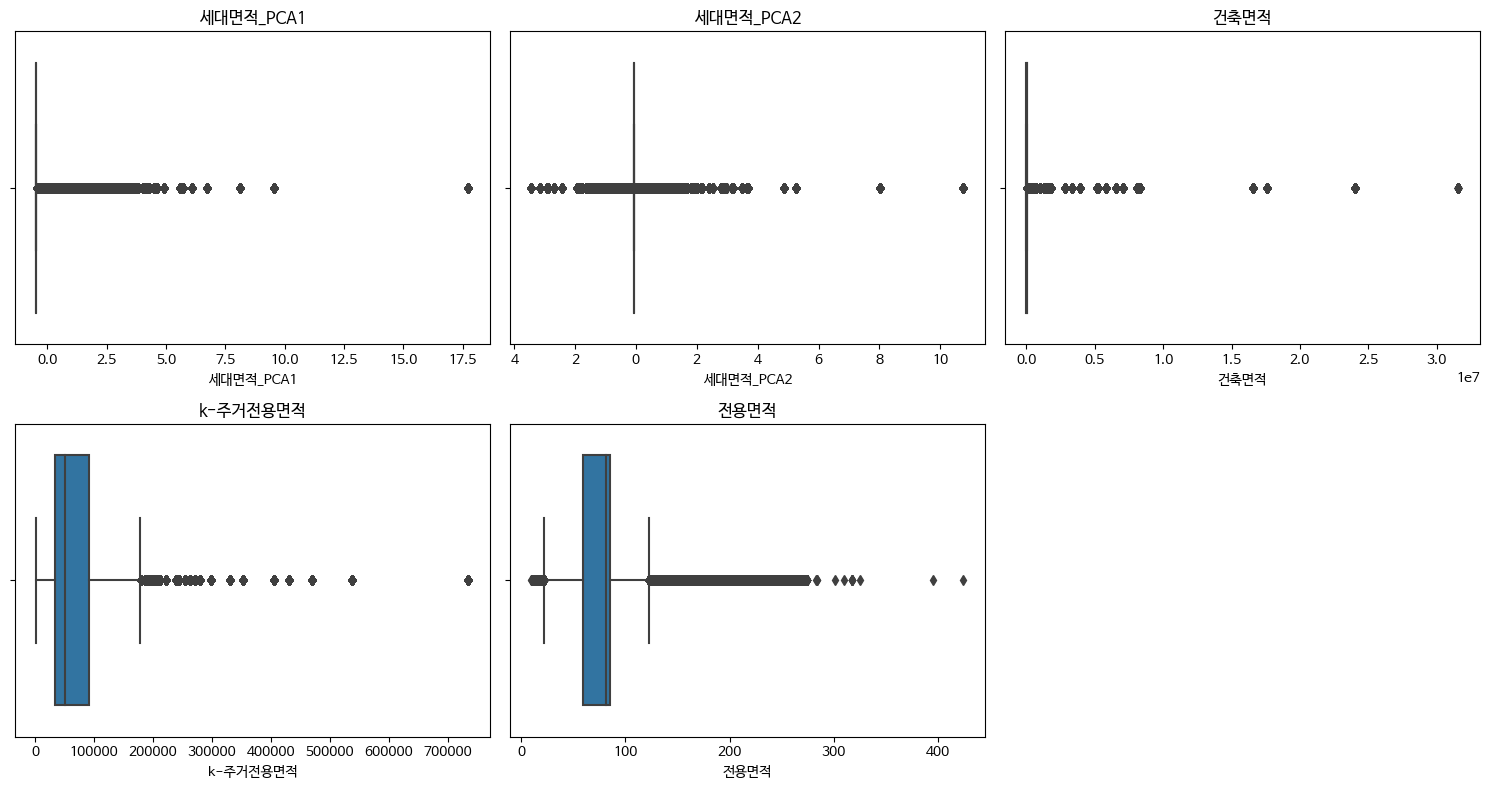

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# 이상치 비율 상위 5개 변수 추출
top_outlier_cols = outlier_df['변수'].head(5)

# Boxplot 시각화
plt.figure(figsize=(15, 8))
for i, col in enumerate(top_outlier_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=train_data[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [44]:
# pca 설명력이 높지도 않고 이상치도 많아서 pca 제거
# 원본 k-전용면적별세대현황(60㎡~85㎡이하) 가져오기

# 1. PCA로 만든 feature 제거
pca_cols = ['세대면적_PCA1', '세대면적_PCA2']
concat_select.drop(columns=pca_cols, inplace=True, errors='ignore')

# 2. 원본에서 특정 변수만 가져와서 추가
selected_feature = 'k-전용면적별세대현황(60㎡~85㎡이하)'
concat_select[selected_feature] = concat[selected_feature]

print("✅ PCA 삭제 및 원본 feature 복원 완료")


✅ PCA 삭제 및 원본 feature 복원 완료


In [45]:
concat_select.head(1)

,시군구,번지,아파트명,전용면적,계약년월,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,건축면적,주차대수,좌표X,좌표Y,target,data,구,동,k-전용면적별세대현황(60㎡~85㎡이하)
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,201712,8,3,1987,아파트,270.0,우성건설,모름,1987-11-21 00:00:00.0,20204.0,4858.0,262.0,127.05721,37.476763,124000.0,0,강남구,개포동,250.0


In [46]:
# concat_select가 아닌 concat에서 가져와서 결측치 확인
# concat에서 가져온 이유 : concat_select에서 pca하면서 feature 지워버림 ㅎㅎ

concat_select['k-전용면적별세대현황(60㎡~85㎡이하)'].isnull().sum()

876170

In [47]:
# 결측치는 동/구/전체 평균으로 채우기

impute2_targets = ['k-전용면적별세대현황(60㎡~85㎡이하)']

for col in impute2_targets:
    # 1차: 동 단위 평균
    concat_select[col] = concat_select.groupby('동')[col].transform(lambda x: x.fillna(x.mean()))
    # 2차: 구 단위 평균 (동 평균이 안 되면 여기서)
    concat_select[col] = concat_select.groupby('구')[col].transform(lambda x: x.fillna(x.mean()))
    # 3차: 전체 평균 (구 평균도 안 되면 여기서)
    concat_select[col].fillna(concat_select[col].mean(), inplace=True)

In [48]:
# 확인
# 리스트 초기화
con_columns_final = []
cat_columns_final = []

# concat_select 기준으로 분리
for col in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[col]):
        con_columns_final.append(col)
    else:
        cat_columns_final.append(col)

# 결과 출력
print("✅ 연속형 변수:", con_columns_final)
print("✅ 범주형 변수:", cat_columns_final)
print(f"📊 총 연속형 변수 개수: {len(con_columns_final)}")
print(f"📁 총 범주형 변수 개수: {len(cat_columns_final)}")


✅ 연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체세대수', 'k-주거전용면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'data', 'k-전용면적별세대현황(60㎡~85㎡이하)']
✅ 범주형 변수: ['시군구', '번지', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '구', '동']
📊 총 연속형 변수 개수: 14
📁 총 범주형 변수 개수: 9


In [49]:
# 다시 IQR 확인

def detect_outliers_iqr(df, columns, iqr_scale=1.5):
    outlier_summary = []

    for col in columns:
        if df[col].isnull().all():
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_scale * IQR
        upper_bound = Q3 + iqr_scale * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_ratio = outlier_count / df.shape[0] * 100

        outlier_summary.append({
            '변수': col,
            '이상치 개수': outlier_count,
            '이상치 비율(%)': round(outlier_ratio, 2)
        })

    return pd.DataFrame(outlier_summary).sort_values('이상치 비율(%)', ascending=False)


In [50]:
# 학습용 데이터만 추출
train_data = concat_select[concat_select['data'] == 0]

# 이상치 탐지 요약표 생성
outlier_df = detect_outliers_iqr(train_data, con_columns_final)

# 출력
import pandas as pd
pd.set_option('display.max_rows', 100)  # 길어도 잘림 방지
display(outlier_df)


,변수,이상치 개수,이상치 비율(%)
7,건축면적,139756,12.49
6,k-주거전용면적,99291,8.87
0,전용면적,89248,7.98
13,k-전용면적별세대현황(60㎡~85㎡이하),85569,7.65
11,target,75622,6.76
8,주차대수,73692,6.59
5,k-전체세대수,63530,5.68
3,층,17009,1.52
4,건축년도,4743,0.42
1,계약년월,0,0.00


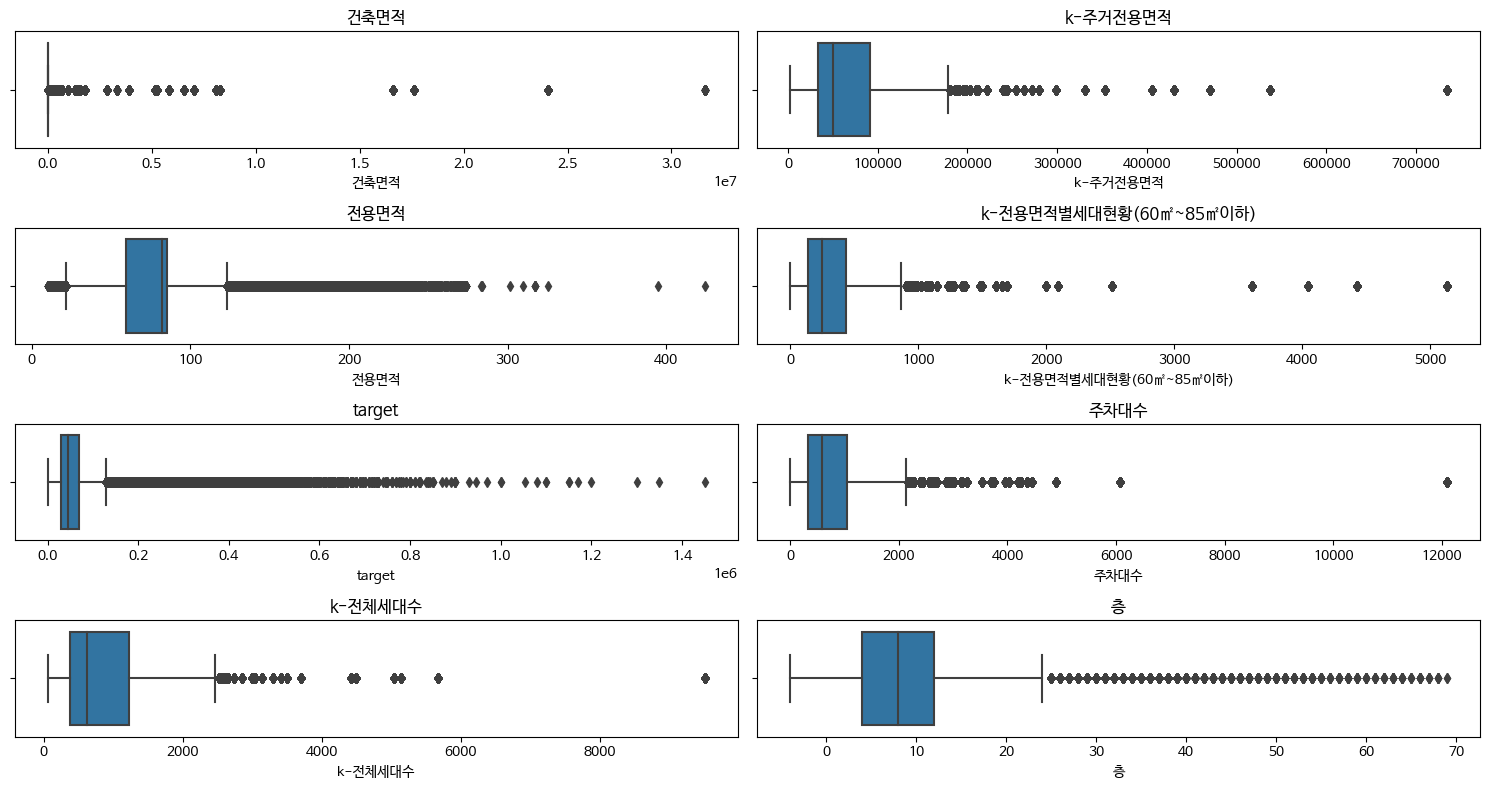

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# 이상치 비율 상위 5개 변수 추출
top_outlier_cols = outlier_df['변수'].head(8)

# Boxplot 시각화
plt.figure(figsize=(15, 8))
for i, col in enumerate(top_outlier_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=train_data[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [52]:
# 이상치 제거 대신 클립 방식 선택

def clip_iqr(df, columns, k=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR
        df[col] = df[col].clip(lower, upper)
    return df

clip_cols = ['건축면적', '전용면적', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-전체세대수', '주차대수']

concat_select = clip_iqr(concat_select, clip_cols)

# 파생변수 만들기

In [53]:
concat_select['세대당_주차대수'] = concat_select['주차대수'] / (concat_select['k-전체세대수'] + 1)

In [54]:
concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [55]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.128094e+06
mean     1.998791e+03
std      9.358540e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [56]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [57]:
concat_select.head(1)

,시군구,번지,아파트명,전용면적,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,건축면적,주차대수,좌표X,좌표Y,target,data,구,동,k-전용면적별세대현황(60㎡~85㎡이하),세대당_주차대수,계약년,계약월,신축여부
0,서울특별시 강남구 개포동,658-1,개포6차우성,79.97,8,3,1987,아파트,270.0,우성건설,모름,1987-11-21 00:00:00.0,20204.0,4858.0,262.0,127.05721,37.476763,124000.0,0,강남구,개포동,250.0,0.96679,2017,12,0


In [58]:
concat_select = concat_select.drop(columns=['시군구'])
concat_select = concat_select.drop(columns=['주차대수'])

In [59]:
concat_select.columns

Index(['번지', '아파트명', '전용면적', '계약일', '층', '건축년도', 'k-단지분류(아파트,주상복합등등)',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-주거전용면적', '건축면적',
       '좌표X', '좌표Y', 'target', 'data', '구', '동', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       '세대당_주차대수', '계약년', '계약월', '신축여부'],
      dtype='object')

In [60]:
concat_select[['좌표X','좌표Y']]

,좌표X,좌표Y
0,127.05721,37.476763
1,127.05721,37.476763
2,127.05721,37.476763
3,127.05721,37.476763
4,127.05721,37.476763
...,...,...
9267,127.10672,37.618870
9268,127.10672,37.618870
9269,127.10672,37.618870
9270,127.10672,37.618870


In [61]:
concat_select = concat_select.rename(columns={
    '좌표X': '경도',
    '좌표Y': '위도'})


In [62]:
subway = pd.read_csv('/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/bus_feature.csv', encoding='utf-8')
bike = pd.read_csv('/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/bike_station.csv', encoding='cp949')
green = pd.read_csv('/root/AI_STAGE/upstageailab-ml-competition-ml-2/1.Data/green_space.csv', encoding='cp949')

In [63]:
# 지하철 데이터로 파생변수 만들기

from sklearn.neighbors import BallTree
# 1. 역이름(호선) 문자열 만들기
subway['역_호선'] = subway['역사명'] + '(' + subway['호선'] + ')'

# 2. 위도/경도 → 라디안
coords_c = np.radians(concat_select[['위도', '경도']].values)
coords_subway = np.radians(subway[['위도', '경도']].values)

# 3. BallTree 생성
tree = BallTree(coords_subway, metric='haversine')
radius_rad = 1000 / 6371000  # 1000m → 라디안

# 4. 반경 내 인덱스 검색
indices_array = tree.query_radius(coords_c, r=radius_rad)

# 5. 이름 목록 만들기
subway_combined = subway['역_호선'].values  # '홍대입구(2호선)' 형태의 np.array

subway_names_list = []
subway_count_list = []

for indices in indices_array:
    names = subway_combined[indices] if len(indices) > 0 else []
    subway_count_list.append(len(names))
    subway_names_list.append(','.join(names))

# 6. 저장
concat_select['지하철_1000m내_개수'] = subway_count_list
concat_select['지하철_1000m내_이름목록'] = subway_names_list


In [64]:
concat_select['지하철_1000m내_개수'].unique

<bound method Series.unique of 0       0
1       0
2       0
3       0
4       0
       ..
9267    2
9268    2
9269    2
9270    2
9271    2
Name: 지하철_1000m내_개수, Length: 1128094, dtype: int64>

In [65]:
concat_select[['지하철_1000m내_개수','지하철_1000m내_이름목록']]

,지하철_1000m내_개수,지하철_1000m내_이름목록
0,0,
1,0,
2,0,
3,0,
4,0,
...,...,...
9267,2,"신내(6호선),신내(경춘선)"
9268,2,"신내(6호선),신내(경춘선)"
9269,2,"신내(6호선),신내(경춘선)"
9270,2,"신내(6호선),신내(경춘선)"


In [66]:
# 지하철 데이터로 파생 변수 만들기 

from sklearn.neighbors import BallTree

# 1. '역이름(호선)' 컬럼 생성
subway['역_호선'] = subway['역사명'] + '(' + subway['호선'] + ')'

# 2. 라디안 변환
coords_c = np.radians(concat_select[['위도', '경도']].values)
coords_subway = np.radians(subway[['위도', '경도']].values)

# 3. BallTree 생성
tree = BallTree(coords_subway, metric='haversine')

# 4. 가장 가까운 역 거리 & 인덱스 조회 (k=1)
distances, indices = tree.query(coords_c, k=1)

# 거리 변환 (라디안 → km)
nearest_distances_km = distances[:, 0] * 6371
nearest_station_names = subway['역_호선'].values[indices[:, 0]]

# 5. concat_select에 저장
concat_select['지하철_최단거리_km'] = nearest_distances_km
concat_select['지하철_최단거리_역명'] = nearest_station_names


In [67]:
concat_select[['지하철_1000m내_개수', '지하철_1000m내_이름목록', '지하철_최단거리_km','지하철_최단거리_역명']]

,지하철_1000m내_개수,지하철_1000m내_이름목록,지하철_최단거리_km,지하철_최단거리_역명
0,0,,1.129775,구룡(분당선)
1,0,,1.129775,구룡(분당선)
2,0,,1.129775,구룡(분당선)
3,0,,1.129775,구룡(분당선)
4,0,,1.129775,구룡(분당선)
...,...,...,...,...
9267,2,"신내(6호선),신내(경춘선)",0.733291,신내(경춘선)
9268,2,"신내(6호선),신내(경춘선)",0.733291,신내(경춘선)
9269,2,"신내(6호선),신내(경춘선)",0.733291,신내(경춘선)
9270,2,"신내(6호선),신내(경춘선)",0.733291,신내(경춘선)


In [68]:
# 버스 데이터로 파생변수 만들기 

from sklearn.neighbors import BallTree

# 1. 위경도 라디안으로 변환 (주의: 위도(Y), 경도(X) 순서)
coords_c= np.radians(concat_select[['위도', '경도']].values)
coords_bus = np.radians(bus[['Y좌표', 'X좌표']].values)

# 2. BallTree 생성 (Haversine 거리 계산용)
tree_bus = BallTree(coords_bus, metric='haversine')

# 3. 가장 가까운 거리와 인덱스 구하기
bus_distances, bus_indices = tree_bus.query(coords_c, k=1)
concat_select['버스_최단거리_km'] = bus_distances[:, 0] * 6371  # km로 변환

# 4. 가장 가까운 버스 정류장 이름 추가
# 정류장명이 들어있는 컬럼명 확인 (예: '정류장명')
bus_stop_names = bus.reset_index(drop=True).loc[bus_indices[:, 0], '정류소명'].values
concat_select['버스_최단거리_정류장'] = bus_stop_names

# 5. 반경 500m 내 버스 정류장 개수 구하기
radius_km = 0.5
radius_rad = radius_km / 6371  # km → 라디안

bus_in_radius = tree_bus.query_radius(coords_c, r=radius_rad)
concat_select['버스_500m내_개수'] = [len(lst) for lst in bus_in_radius]


In [69]:
concat_select.head(1)

,번지,아파트명,전용면적,계약일,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-주거전용면적,건축면적,경도,위도,target,data,구,동,k-전용면적별세대현황(60㎡~85㎡이하),세대당_주차대수,계약년,계약월,신축여부,지하철_1000m내_개수,지하철_1000m내_이름목록,지하철_최단거리_km,지하철_최단거리_역명,버스_최단거리_km,버스_최단거리_정류장,버스_500m내_개수
0,658-1,개포6차우성,79.97,8,3,1987,아파트,270.0,우성건설,모름,1987-11-21 00:00:00.0,20204.0,4858.0,127.05721,37.476763,124000.0,0,강남구,개포동,250.0,0.96679,2017,12,0,0,,1.129775,구룡(분당선),0.061783,개포우성아파트,13


In [70]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 31 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   번지                      1128094 non-null  object 
 1   아파트명                    1128094 non-null  object 
 2   전용면적                    1128094 non-null  float64
 3   계약일                     1128094 non-null  int64  
 4   층                       1128094 non-null  int64  
 5   건축년도                    1128094 non-null  int64  
 6   k-단지분류(아파트,주상복합등등)      1128094 non-null  object 
 7   k-전체세대수                 1128094 non-null  float64
 8   k-건설사(시공사)              1128094 non-null  object 
 9   k-시행사                   1128094 non-null  object 
 10  k-사용검사일-사용승인일           1128094 non-null  object 
 11  k-주거전용면적                1128094 non-null  float64
 12  건축면적                    1128094 non-null  float64
 13  경도                      1128094 non-null  float64
 14  위도   

In [71]:
# 리스트 초기화
con_columns_final = []
cat_columns_final = []

# concat_select 기준으로 분리
for col in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[col]):
        con_columns_final.append(col)
    else:
        cat_columns_final.append(col)

# 결과 출력
print("✅ 연속형 변수:", con_columns_final)
print("✅ 범주형 변수:", cat_columns_final)
print(f"📊 총 연속형 변수 개수: {len(con_columns_final)}")
print(f"📁 총 범주형 변수 개수: {len(cat_columns_final)}")


✅ 연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체세대수', 'k-주거전용면적', '건축면적', '경도', '위도', 'target', 'data', 'k-전용면적별세대현황(60㎡~85㎡이하)', '세대당_주차대수', '신축여부', '지하철_1000m내_개수', '지하철_최단거리_km', '버스_최단거리_km', '버스_500m내_개수']
✅ 범주형 변수: ['번지', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '구', '동', '계약년', '계약월', '지하철_1000m내_이름목록', '지하철_최단거리_역명', '버스_최단거리_정류장']
📊 총 연속형 변수 개수: 18
📁 총 범주형 변수 개수: 13


target                    1.000000
전용면적                      0.505094
k-주거전용면적                  0.283025
지하철_1000m내_개수             0.225557
k-전용면적별세대현황(60㎡~85㎡이하)    0.175836
신축여부                      0.169357
k-전체세대수                   0.157439
층                         0.153176
버스_최단거리_km                0.140886
세대당_주차대수                  0.131394
경도                        0.102674
건축년도                      0.056041
계약일                       0.009348
건축면적                     -0.024440
지하철_최단거리_km              -0.136589
버스_500m내_개수              -0.153951
위도                       -0.304205
data                           NaN
Name: target, dtype: float64


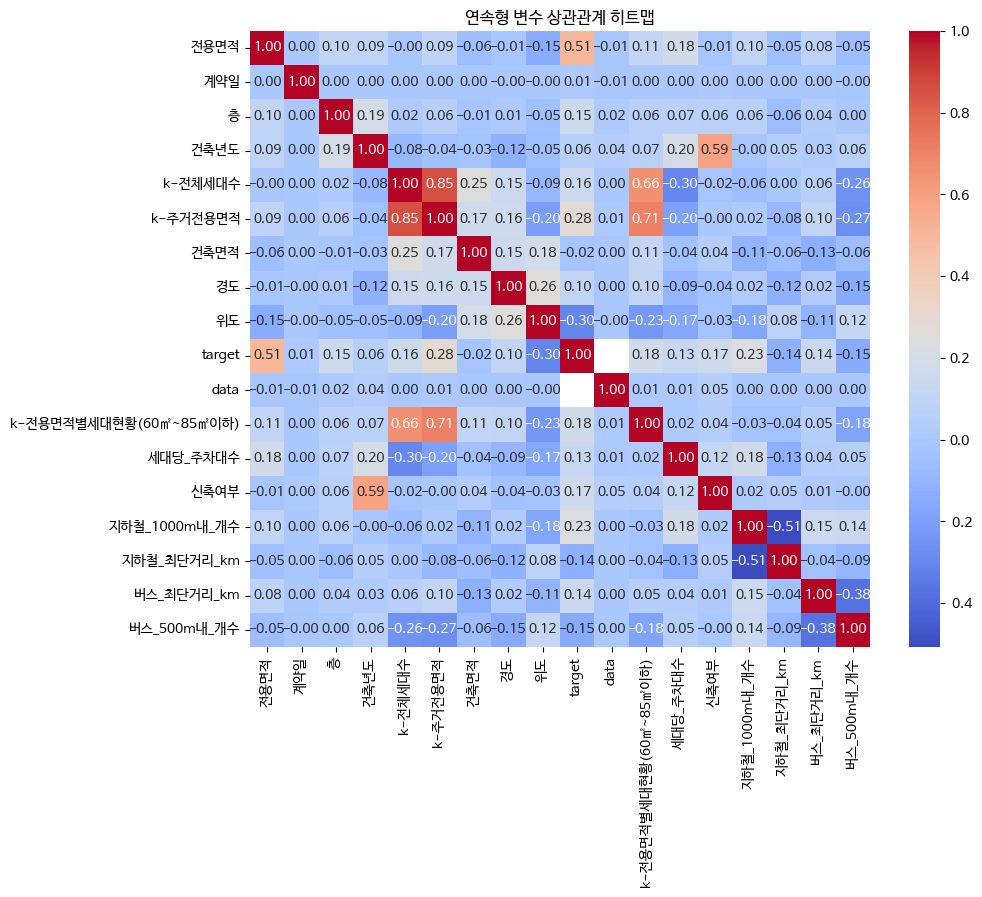

In [72]:
# 연속형 변수 시각화

correlation_with_target = concat_select[con_columns_final].corr()['target'].sort_values(ascending=False)
print(correlation_with_target)

plt.figure(figsize=(10, 8))
sns.heatmap(concat_select[con_columns_final].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("연속형 변수 상관관계 히트맵")
plt.show()


In [73]:
concat_select = concat_select.drop(columns=['k-주거전용면적'])
concat_select = concat_select.drop(columns=['k-전용면적별세대현황(60㎡~85㎡이하)'])

In [74]:
concat_select.columns

Index(['번지', '아파트명', '전용면적', '계약일', '층', '건축년도', 'k-단지분류(아파트,주상복합등등)',
       'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', '건축면적', '경도', '위도',
       'target', 'data', '구', '동', '세대당_주차대수', '계약년', '계약월', '신축여부',
       '지하철_1000m내_개수', '지하철_1000m내_이름목록', '지하철_최단거리_km', '지하철_최단거리_역명',
       '버스_최단거리_km', '버스_최단거리_정류장', '버스_500m내_개수'],
      dtype='object')

In [75]:
concat_select = concat_select.drop(columns=['위도'])
concat_select = concat_select.drop(columns='경도')
concat_select = concat_select.drop(columns=['계약일'])

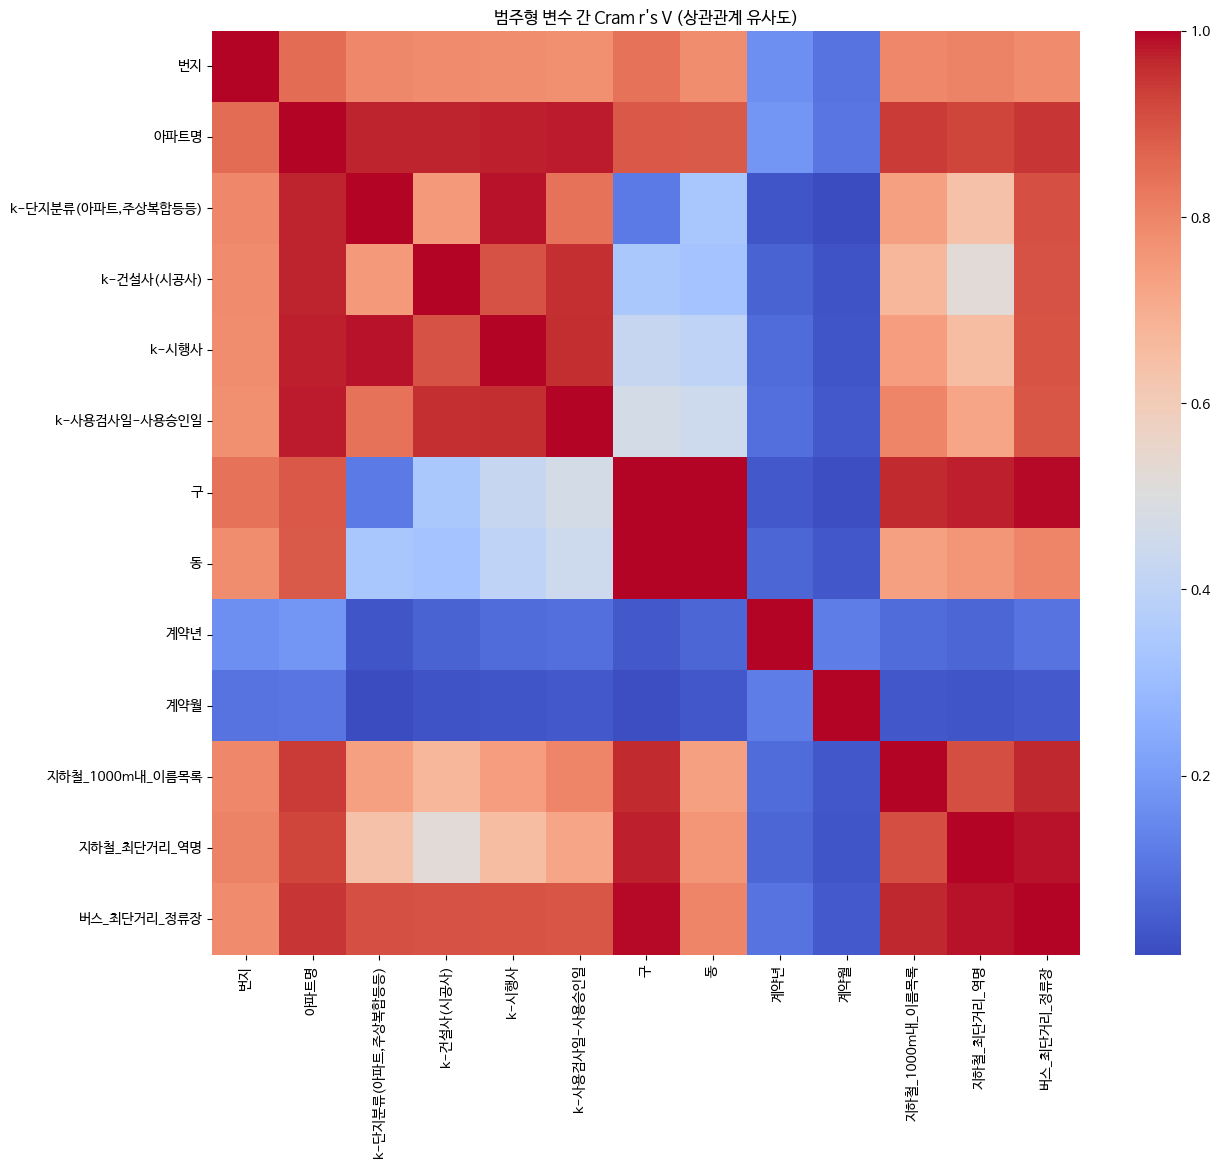

In [76]:
# 범주형 feature들 관계 보기

from scipy.stats import chi2_contingency

# Cramér's V 계산 함수
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# 범주형 변수 리스트
cat_cols = cat_columns2 = cat_columns_final  # 이미 나눈 리스트

# 결과 저장용 매트릭스
cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramer_matrix.loc[col1, col2] = 1.0
        else:
            try:
                cramer_matrix.loc[col1, col2] = cramers_v(concat_select[col1], concat_select[col2])
            except:
                cramer_matrix.loc[col1, col2] = np.nan

plt.figure(figsize=(14, 12))
sns.heatmap(cramer_matrix.astype(float), cmap='coolwarm', annot=False)
plt.title("범주형 변수 간 Cramér's V (상관관계 유사도)")
plt.show()


In [77]:
threshold = 0.8
high_corr_pairs = []

for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        col1, col2 = cat_cols[i], cat_cols[j]
        val = cramer_matrix.loc[col1, col2]
        if pd.notnull(val) and float(val) >= threshold:
            high_corr_pairs.append((col1, col2, float(val)))

for col1, col2, score in sorted(high_corr_pairs, key=lambda x: -x[2]):
    print(f"🔁 {col1} ↔ {col2} : Cramér's V = {score:.2f}")


🔁 구 ↔ 동 : Cramér's V = 1.00
🔁 구 ↔ 버스_최단거리_정류장 : Cramér's V = 0.99
🔁 지하철_최단거리_역명 ↔ 버스_최단거리_정류장 : Cramér's V = 0.99
🔁 k-단지분류(아파트,주상복합등등) ↔ k-시행사 : Cramér's V = 0.99
🔁 아파트명 ↔ k-사용검사일-사용승인일 : Cramér's V = 0.98
🔁 아파트명 ↔ k-시행사 : Cramér's V = 0.98
🔁 구 ↔ 지하철_최단거리_역명 : Cramér's V = 0.97
🔁 아파트명 ↔ k-단지분류(아파트,주상복합등등) : Cramér's V = 0.97
🔁 아파트명 ↔ k-건설사(시공사) : Cramér's V = 0.97
🔁 지하철_1000m내_이름목록 ↔ 버스_최단거리_정류장 : Cramér's V = 0.97
🔁 구 ↔ 지하철_1000m내_이름목록 : Cramér's V = 0.96
🔁 k-시행사 ↔ k-사용검사일-사용승인일 : Cramér's V = 0.96
🔁 k-건설사(시공사) ↔ k-사용검사일-사용승인일 : Cramér's V = 0.96
🔁 아파트명 ↔ 버스_최단거리_정류장 : Cramér's V = 0.95
🔁 아파트명 ↔ 지하철_1000m내_이름목록 : Cramér's V = 0.94
🔁 아파트명 ↔ 지하철_최단거리_역명 : Cramér's V = 0.92
🔁 지하철_1000m내_이름목록 ↔ 지하철_최단거리_역명 : Cramér's V = 0.91
🔁 k-단지분류(아파트,주상복합등등) ↔ 버스_최단거리_정류장 : Cramér's V = 0.91
🔁 k-건설사(시공사) ↔ 버스_최단거리_정류장 : Cramér's V = 0.90
🔁 k-건설사(시공사) ↔ k-시행사 : Cramér's V = 0.90
🔁 k-시행사 ↔ 버스_최단거리_정류장 : Cramér's V = 0.90
🔁 k-사용검사일-사용승인일 ↔ 버스_최단거리_정류장 : Cramér's V = 0.90
🔁 아파트명 ↔ 구 : Cramér's V = 0.89
🔁

In [78]:
concat_select[['k-건설사(시공사)','k-시행사']]

,k-건설사(시공사),k-시행사
0,우성건설,모름
1,우성건설,모름
2,우성건설,모름
3,우성건설,모름
4,우성건설,모름
...,...,...
9267,한신공영(주),SH공사
9268,한신공영(주),SH공사
9269,한신공영(주),SH공사
9270,한신공영(주),SH공사


In [79]:
concat_select = concat_select.drop(columns=['k-시행사'])

In [80]:
import pandas as pd

# 리스트 초기화
con_columns_final = []
cat_columns_final = []

# concat_select 기준으로 분리
for col in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[col]):
        con_columns_final.append(col)
    else:
        cat_columns_final.append(col)

# 결과 출력
print("✅ 연속형 변수:", con_columns_final)
print("✅ 범주형 변수:", cat_columns_final)
print(f"📊 총 연속형 변수 개수: {len(con_columns_final)}")
print(f"📁 총 범주형 변수 개수: {len(cat_columns_final)}")


✅ 연속형 변수: ['전용면적', '층', '건축년도', 'k-전체세대수', '건축면적', 'target', 'data', '세대당_주차대수', '신축여부', '지하철_1000m내_개수', '지하철_최단거리_km', '버스_최단거리_km', '버스_500m내_개수']
✅ 범주형 변수: ['번지', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', '구', '동', '계약년', '계약월', '지하철_1000m내_이름목록', '지하철_최단거리_역명', '버스_최단거리_정류장']
📊 총 연속형 변수 개수: 13
📁 총 범주형 변수 개수: 12


# 모델 학습

In [81]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 data 칼럼을 이용합니다.
dt_train = concat_select.query('data==0')
dt_test = concat_select.query('data==1')

# 이제 data 칼럼은 drop해줍니다.
dt_train.drop(['data'], axis = 1, inplace=True)
dt_test.drop(['data'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 24) (9272, 24)


In [82]:
# 범주형 변수 인코딩

# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_final = []
categorical_columns_final = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_final.append(column)
    else:
        categorical_columns_final.append(column)

print("연속형 변수:", continuous_columns_final)
print("범주형 변수:", categorical_columns_final)

연속형 변수: ['전용면적', '층', '건축년도', 'k-전체세대수', '건축면적', 'target', '세대당_주차대수', '신축여부', '지하철_1000m내_개수', '지하철_최단거리_km', '버스_최단거리_km', '버스_500m내_개수']
범주형 변수: ['번지', '아파트명', 'k-단지분류(아파트,주상복합등등)', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', '구', '동', '계약년', '계약월', '지하철_1000m내_이름목록', '지하철_최단거리_역명', '버스_최단거리_정류장']


In [83]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_final ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:03<00:00,  3.63it/s]


In [84]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [85]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [86]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
# 주피터나 코랩 환경에서는 실행 됨
#%%time
# model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
# model.fit(X_train, y_train)
# pred = model.predict(X_val)

import time

start = time.time()

model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

end = time.time()
print(f"⏱ 실행 시간: {end - start:.2f}초")


⏱ 실행 시간: 7.08초


In [87]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 9451.619003207834


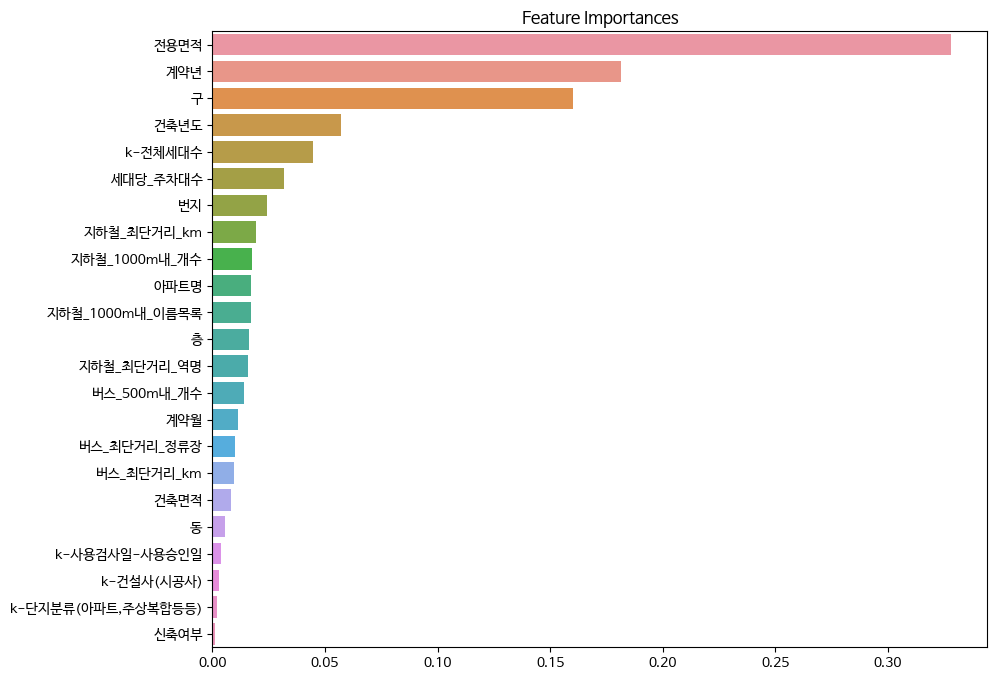

In [88]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [91]:
# 중요도 기준 정렬
importances = model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({"feature": features, "importance": importances})
importance_df = importance_df.sort_values(by="importance", ascending=False)

# 상위 N개만 선택
top_n = 10  # 또는 15, 20 등
top_features = importance_df["feature"].head(top_n).tolist()

# 선택된 피처로 재구성
X_train_selected = X_train[top_features]
X_val_selected = X_val[top_features]


In [92]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [93]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model_com4', 'wb') as f:
    pickle.dump(model, f)

In [94]:
# valid prediction

# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [95]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

# inference

In [ ]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,아파트명,전용면적,층,건축년도,"k-단지분류(아파트,주상복합등등)",k-전체세대수,k-건설사(시공사),k-사용검사일-사용승인일,건축면적,target,구,동,세대당_주차대수,계약년,계약월,신축여부,지하철_1000m내_개수,지하철_1000m내_이름목록,지하철_최단거리_km,지하철_최단거리_역명,버스_최단거리_km,버스_최단거리_정류장,버스_500m내_개수
0,4732,328,79.9700,5,1987,3,270.0,241,29,4858.00,NaN,0,8,0.966790,16,6,0,0,0,1.129775,36,0.061783,54,13
1,4707,329,108.2017,10,2021,3,232.0,289,660,2724.46,NaN,0,8,1.309013,16,7,1,5,72,0.306673,36,0.125972,98,15


In [97]:
# 저장된 모델을 불러옵니다.
with open('saved_model_com4', 'rb') as f:
    model = pickle.load(f)

In [100]:
%%time
X_test_selected = X_test[top_features]

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test_selected)

CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 38.5 ms


In [101]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([201109.03174603, 325632.05166667, 313436.08333333, ...,
        96267.34621212,  67056.7797619 ,  67630.36111111])

# 예측값 저장

In [102]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('sub_250715_rf_v4_k.csv', index=False)